In [6]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 19.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d88383bc530934812fe7148d01e987529dcd0bba232bfdb5e5c35ec556470771
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

In [3]:
df = spark.read.csv('diabetes.csv', header= True, inferSchema=True)

In [77]:
sc = spark.sparkContext

In [4]:
df

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, Pedigree: double, Age: int, Outcome: int]

In [5]:
df.count()

768

In [8]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+--------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|Pedigree|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+--------+---+-------+
|          6|    148|           72|           35|      0|33.6|   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+--------+---+-------+
only showing top 5 rows



In [10]:
df.summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|          Pedigree|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|               768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.952217567727642|115.244002351338

In [12]:
pdf = df.toPandas()

In [13]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int32  
 1   Glucose        768 non-null    int32  
 2   BloodPressure  768 non-null    int32  
 3   SkinThickness  768 non-null    int32  
 4   Insulin        768 non-null    int32  
 5   BMI            768 non-null    float64
 6   Pedigree       768 non-null    float64
 7   Age            768 non-null    int32  
 8   Outcome        768 non-null    int32  
dtypes: float64(2), int32(7)
memory usage: 33.1 KB


In [14]:
# Check the balance of data
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [16]:
pdf['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

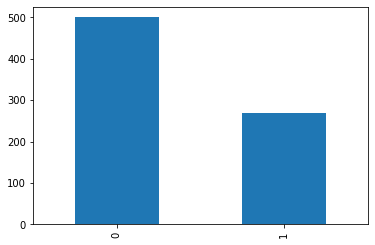

In [17]:
pdf['Outcome'].value_counts().plot.bar()

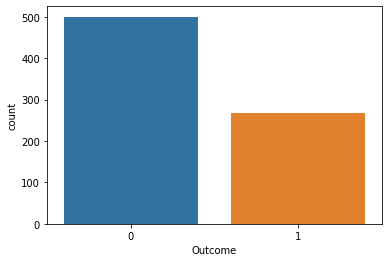

In [19]:
import seaborn as sns
sns.countplot(x = pdf['Outcome'])

In [23]:
round(pdf['Outcome'].value_counts()[0] / len(pdf), 2) * 100

65.0

In [24]:
round(pdf['Outcome'].value_counts()[1] / len(pdf), 2) * 100

35.0

In [27]:
pdf.isnull().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
Pedigree         0
Age              0
Outcome          0
dtype: int64

In [28]:
from pyspark.sql.functions import isnull, when, count, col

In [29]:
# no missing values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+--------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|Pedigree|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+--------+---+-------+
|          0|      0|            0|            0|      0|  0|       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+--------+---+-------+



In [30]:
# Assemble the features
required_features = ['Glucose','BloodPressure','BMI','Age']

In [31]:
pdf[required_features]

,Glucose,BloodPressure,BMI,Age
0,148,72,33.6,50
1,85,66,26.6,31
2,183,64,23.3,32
3,89,66,28.1,21
4,137,40,43.1,33
...,...,...,...,...
763,101,76,32.9,63
764,122,70,36.8,27
765,121,72,26.2,30
766,126,60,30.1,47


In [32]:
# import the vector assembler class
from pyspark.ml.feature import VectorAssembler

In [33]:
# create the object
assembler = VectorAssembler(inputCols=required_features,
                            outputCol='features')

In [34]:
transformed_data = assembler.transform(df)

In [35]:
transformed_data.show(5)

+-----------+-------+-------------+-------------+-------+----+--------+---+-------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|Pedigree|Age|Outcome|            features|
+-----------+-------+-------------+-------------+-------+----+--------+---+-------+--------------------+
|          6|    148|           72|           35|      0|33.6|   0.627| 50|      1|[148.0,72.0,33.6,...|
|          1|     85|           66|           29|      0|26.6|   0.351| 31|      0|[85.0,66.0,26.6,3...|
|          8|    183|           64|            0|      0|23.3|   0.672| 32|      1|[183.0,64.0,23.3,...|
|          1|     89|           66|           23|     94|28.1|   0.167| 21|      0|[89.0,66.0,28.1,2...|
|          0|    137|           40|           35|    168|43.1|   2.288| 33|      1|[137.0,40.0,43.1,...|
+-----------+-------+-------------+-------------+-------+----+--------+---+-------+--------------------+
only showing top 5 rows



In [36]:
# split the data in train and test
training_data, test_data = transformed_data.randomSplit([0.75, 0.25],
                                                        seed = 0)

In [37]:
training_data.count()

573

In [38]:
test_data.count()

195

In [52]:
training_data.groupby('Outcome').count().select('count')

DataFrame[count: bigint]

In [42]:
test_data.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|   78|
|      0|  117|
+-------+-----+



In [53]:
from pyspark.ml.classification import DecisionTreeClassifier

In [54]:
dt = DecisionTreeClassifier(labelCol='Outcome', featuresCol='features')

In [55]:
# train the algorithm
model = dt.fit(training_data)

In [56]:
# predictions on unseen data
predictions = model.transform(test_data)

In [59]:
predictions.show(5)

+-----------+-------+-------------+-------------+-------+----+--------+---+-------+--------------------+-------------+--------------------+----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|Pedigree|Age|Outcome|            features|rawPrediction|         probability|prediction|
+-----------+-------+-------------+-------------+-------+----+--------+---+-------+--------------------+-------------+--------------------+----------+
|          0|     57|           60|            0|      0|21.7|   0.735| 67|      0|[57.0,60.0,21.7,6...|  [65.0,16.0]|[0.80246913580246...|       0.0|
|          0|     99|            0|            0|      0|25.0|   0.253| 22|      0|[99.0,0.0,25.0,22.0]|  [117.0,1.0]|[0.99152542372881...|       0.0|
|          0|    100|           70|           26|     50|30.8|   0.597| 21|      0|[100.0,70.0,30.8,...|  [117.0,1.0]|[0.99152542372881...|       0.0|
|          0|    102|           64|           46|     78|40.6|   0.496| 21|      0|[102.0,64.0

In [66]:
pred = predictions.select('prediction').toPandas()

In [65]:
actual = test_data.select('Outcome').toPandas()

In [64]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

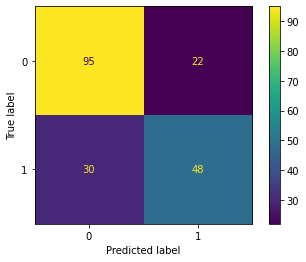

In [67]:
ConfusionMatrixDisplay.from_predictions(actual, pred)

In [68]:
accuracy_score(actual, pred)

0.7333333333333333

In [69]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       117
           1       0.69      0.62      0.65        78

    accuracy                           0.73       195
   macro avg       0.72      0.71      0.72       195
weighted avg       0.73      0.73      0.73       195



In [70]:
# import the evaluation class
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [71]:
eval = MulticlassClassificationEvaluator(labelCol='Outcome',
                                         metricName='accuracy')

In [72]:
print('Accuracy:', eval.evaluate(predictions))

Accuracy: 0.7333333333333333


In [78]:
new = sc.parallelize([89,66,25.2,34])  # New person

In [82]:
import pyspark
help(pyspark.ml.classification)

Help on module pyspark.ml.classification in pyspark.ml:

NAME
    pyspark.ml.classification

DESCRIPTION
    # Licensed to the Apache Software Foundation (ASF) under one or more
    # contributor license agreements.  See the NOTICE file distributed with
    # this work for additional information regarding copyright ownership.
    # The ASF licenses this file to You under the Apache License, Version 2.0
    # (the "License"); you may not use this file except in compliance with
    # the License.  You may obtain a copy of the License at
    #
    #    http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.
    #

CLASSES
    pyspark.ml.base.Estimator(pyspark.ml.par